In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
from datetime import date
from tqdm.notebook import tqdm_notebook
import math
import time
import pyfolio as pf
%matplotlib inline

C:\Users\Amaury\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
def get_data(assets, start_date, end_date, time_interval):
    return yf.download(assets, 
                          start = start_date, 
                          end = end_date,
                          interval = time_interval,
                          threads = True,
                          progress = False)['Adj Close']

In [20]:
assets  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX", "Amc"]


# ----------- DATES ------
start_train_date = '2020-01-01'
end_train_date = '2021-01-01'
start_test_date = end_train_date
end_test_date = date.today()
interval = "1d"


all_stocks = get_data(assets, '2014-01-01', '2022-01-01', "1d")

"""returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns_raw = returns.iloc[1: , :]

int((returns_raw.shape[0]-253)/20)"""

'returns = np.log(all_stocks/all_stocks.shift(1))\nreturns.fillna(0)\nreturns_raw = returns.iloc[1: , :]\n\nint((returns_raw.shape[0]-253)/20)'

Initialisation des variables

In [4]:
def init(Money, periode_trades):
    
    global memo, X, cash, argent_gagne, couts_transaction, s, argent_fait, pf_value, pos, pos2, bounds, nb_actifs, returns_raw
    
    # Variables utilisées dans l'algorithme

    returns = np.log(all_stocks/all_stocks.shift(periode_trades))
    returns.fillna(0)
    returns_raw = returns.iloc[periode_trades: , :]
    
    cash = Money
    win = 0
    argent_gagne = 0
    cout = 0
    couts_transaction = 0
    s = 0
    nb_actifs = returns_raw.shape[1]
    argent_fait = [Money]
    pf_value = 0
    X = []
    memo = {}

    # pos = portefeuille initialement vide
    pos = np.array([0 for i in range(nb_actifs)])


Fonctions objectif et coûts de transaction

In [5]:
def objective_cov(pos, returns, covar_matrix, alpha, memoisation, pospre,vp):
    global s
    if memoisation:
        x = str(pos)
        if x not in memo:
            s = pos@covar_matrix@pos - alpha*returns@pos +TC(pospre,pos,vp)
            memo[x] = s
        else:
            s = memo[x]
            # print("la mémo a été utile")
    else:
        s = pos@covar_matrix@pos - alpha*returns@pos +TC(pospre,pos,vp)
    
    # print(f"Valeur de la fonction objectif : {s.round(3)}")
    return s

def TC(pos,pos2, vp):
    return lamb*(np.sum(np.array([np.abs((pos2[i]-pos[i])) for i in range(nb_actifs)])))


Import des données roulantes à l'étape i

In [6]:
def import_donnees(etape):
    global X
    
    # import des données roulantes, on calcule à partir des données de l'année précédente
    log_returns = returns_raw.iloc[etape:253+etape, :]
    # calcul des expected returns (par Standard Moving Average, et on prend une période plus courte)
    expected_returns_SMA = log_returns.iloc[-jours_returns:: ,:].mean()
    # calcul des expected returns (par Exponential Moving Average)
    expected_returns_EMA = log_returns.iloc[-jours_returns*3:: ,:].ewm(span=jours_returns, adjust=False).mean().iloc[-1,:]
    
    # calcul de la matrice de covariance
    covar = log_returns.cov().copy()
    covar_matrix = covar.to_numpy()
    
    correl = log_returns.corr().copy()
    correl_matrix = correl.to_numpy()

    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+etape::].values[0]
    vp2 = all_stocks[253+etape+periode_trades::].values[0]
    
    expected_returns = np.array([expected_returns_EMA[i]*vp[i] for i in range(nb_actifs)])

    #X.append(str(returns_raw.iloc[253+etape].name).split()[0])
    #print(str(log_returns.iloc[-1].name).split()[0])
    memo = {}
    
    return expected_returns, covar_matrix, vp, vp2, memo

Fonctions contraintes

In [7]:
#def cons1(x,Money,vp):
    # on ne peut pas investir plus que ce qu'on possède
    #return Money - np.sum([x[i]*vp[i] for i in range(nb_actifs)])

def cons2(x,cash,pos,vp):
    # pour payer les coûts de transaction, il faut soit utiliser du cash soit vendre des positions (pour un prix -delta_P*vp)
    return cash + np.sum([(pos[i]-x[i])*vp[i] for i in range(nb_actifs)]) - TC(pos,x,vp)

def cons3(x,returns,vp, gain_cible):
    # on veut au moins que le gain soit supérieur à gain_cible
    return np.sum([returns[i]*vp[i]*x[i] for i in range(nb_actifs)]) - gain_cible
def cons4(x,pos,dPmax):
    return dPmax-max([abs(x[i]-pos[i]) for i in range (nb_actifs)])

Calcul de l'optimisation roulante

In [22]:
D_lambd = []
D = []
def compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades, nb_etapes, gain_cible, debug=True):
    

    global pf_value, pos, pos2, argent_gagne, cout, win, cash, couts_transaction, pospre
    global Test_pos, Test_TC, Test_money, Test_cash, TCs, Moneys, Cashs
    
    init(Money, periode_trades)
    Test_pos = [[0 for i in range(nb_actifs)]]
    Test_TC = [0]
    Test_money = [0]
    Test_cash = [0]
    TCs = [0]
    Moneys = [0]
    Cashs = [0]
    if debug:
        print("Argent injecté au départ:", Money)


    for i in tqdm_notebook(range(min(nb_etapes,int((returns_raw.shape[0]-253)/periode_trades)))):

        # calcul des returns, de la matrice de variance, des vecteurs prix
        returns, covar_matrix, vp, vp2, memo = import_donnees(i*periode_trades)

        cons = (#{"type":"ineq", "fun": lambda x: cons1(x,Money,vp)}, --> contrainte finalement inutile vis à vis de la seconde
               #{"type": "ineq", "fun": lambda x: cons2(x,cash,pos,vp)},
               {"type": "ineq", "fun": lambda x: cons3(x,returns,vp, gain_cible)},
            {"type": "ineq", "fun": lambda x: cons4(x,pos,dPmax)}
            
               )
        
        bounds = Bounds(-Pos_max_par_actif, Pos_max_par_actif)
        
        # calcul du vecteur position
        p = minimize(objective_cov, pos, 
                 method = "SLSQP",
                 bounds = bounds,
                 constraints = cons,
                args=(returns, covar_matrix, alpha, memoisation, pos,vp),
                options={'maxiter': 300, 'ftol':1e-10})
        if not p.success:
            print("False",p.message)
            #newpos=pos
        newpos=p.x
            
        cout = TC(pos,newpos, vp)
        
        TCs.append(cout)
        test_cout = TC(Test_pos[-1],[fact*newpos[i] for i in range(len(newpos))],vp)
        Test_TC.append(test_cout)
        """
        print(cons1(p.x,Money,vp))
        print(cons2(p.x,cash,pos,vp))
        print("gain espéré",cons3(p.x,returns,vp,gain_cible)+gain_cible)"""
        
        couts_transaction += cout

        pos = newpos # les positions prises en fin de journée
        Test_pos.append([fact*pos[i] for i in range(len(pos))])
        
        pf2_value = np.sum([pos[i]*vp[i] for i in range(nb_actifs)])


        cash_restant = Money - (pf2_value + cout) # = valeur totale à t-1 - argent ivesti à t
        cash = cash_restant # l'argent que l'algo décide de ne pas investir
        
        test_cash = Test_money[-1] - np.sum([Test_pos[-1][i]*vp[i] for i in range(nb_actifs)]) - test_cout
        Test_cash.append(test_cash)
        Cashs.append(cash)

        if debug:
            print("\n","Etape {}:".format(i))

            # affichage des valeurs numériques
            print('\033[94m'+"Somme des positions: "+str(pf2_value)+'\033[0m')
            print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
            print("cash :", cash.round(6))
            print(f"La valeur de la fonction objectif:{s}")

        # mise à jour à chaque actualisation des prix
        pf_value = np.sum([pos[i]*vp2[i] for i in range(nb_actifs)])
        Money = pf_value + cash
        Test_money.append(np.sum([Test_pos[-1][i]*vp2[i] for i in range(nb_actifs)]) + test_cash)
        argent_fait.append(Money)
        D.append(argent_fait)
        D_lambd.append(argent_fait)
        win = pf_value - pf2_value
        argent_gagne += win
        if debug:
            print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
            print('\033[95m'+"Argent généré sans TC : "+str(win)+'\033[0m')
            print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")

        
        """print('\033[95m'+"Gain réel sans TC : "+str(win)+'\033[0m')
        print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
        print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")"""
        
    if debug:
        print("\n","fin du calcul")

    print('\033[95m'+"Argent total généré sans TC : "+str(argent_gagne)+'\033[0m')
    print('\033[92m'+"Coûts totaux de transaction: "+str(couts_transaction)+'\033[0m')
    print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")


False Iteration limit reached
False Iteration limit reached
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Iteration limit reached
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Iteration limit reached
False Inequality constraints incompatible
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality const

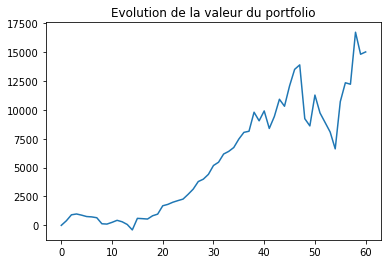

In [31]:
# Paramètres modifiables

lamb = 0.01 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
alpha = 1 # importance accordée à l'expected return
Money = 0 # argent alloué pour l'investissement initial
Pos_max_par_actif = 10000 # quantité maximale d'argent investi par actif
jours_returns = 10 # les n derniers jours qui servent pour calculer les expected returns
periode_trades = 20 # le nombre de jours ouvrés qui séparent chaque décision
memoisation = True
dPmax = 10
gain_cible = 0.015
fact=10000

start = time.time()
compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades,60, gain_cible, False)
end = time.time()
print('\033[90m'+"Temps d'exécution: "+format(end-start)+'\033[0m')


plt.plot(argent_fait)
plt.title("Evolution de la valeur du portfolio")
plt.show()

In [10]:
print("Pente moyenne :", int(10000*argent_fait[-1]/(25))/10000,"par période")
L=[]
print(argent_fait)
for i in range(2,25):
    L.append((argent_fait[i]-argent_fait[i-1])/argent_fait[i-1])
test = np.array(L)
print(np.mean(test))
print(L)

Pente moyenne : 510.4401 par période
[0, 339.2998371672138, 826.4252152889535, 899.7641730596615, 995.0660564188729, 932.5371051235888, 1058.7336718776912, 1252.2775344627378, 1361.4647725014415, 1350.9401901821307, 1152.5448555705166, 1369.259069030827, 1387.192982549208, 1539.484053168821, 1604.6669200081997, 1333.6137731479048, 1270.774149754653, 1220.4155024081624, 1091.2448403008607, 1115.3527535603353, 1331.2769812811857, 1294.225679521839, 1225.9136333332804, 1191.2078865494254, 1104.8283916050423, 1398.0311053994592, 1637.3089952351975, 1926.266931326013, 1979.5703321679357, 2179.9264222684396, 2365.1804113335193, 2620.2956543186565, 2758.6820251576046, 2821.0961420593394, 2824.9174436624626, 3037.9943775991687, 3208.5575827408866, 3365.018974914162, 3766.853776967232, 3363.0144528763367, 3580.710834143888, 4156.0829593833005, 4385.624684983857, 4976.371191521328, 4798.815807702402, 5783.305911429612, 6904.094231551448, 6783.512625978721, 8775.467795380524, 8491.39820587022, 10

Test

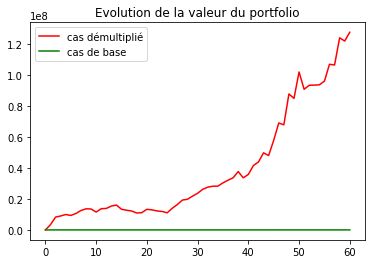

In [11]:
plt.plot(Test_money,'r', label="cas démultiplié")
plt.plot(argent_fait,'g', label="cas de base")
plt.legend()
plt.title("Evolution de la valeur du portfolio")
plt.show()

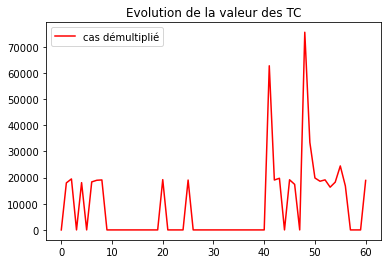

In [12]:
plt.plot(Test_TC,'r', label="cas démultiplié")
#plt.plot([TCs[i] for i in range(len(TCs))],'g', label="cas de base")
plt.legend()
plt.title("Evolution de la valeur des TC")
plt.show()

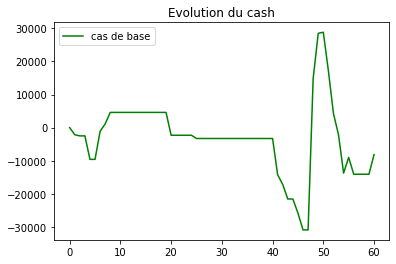

In [13]:
#plt.plot(Test_cash,'r', label="cas démultiplié")
plt.plot([Cashs[i] for i in range(len(Cashs))],'g', label="cas de base")
plt.legend()
plt.title("Evolution du cash")
plt.show()

Calcul du drawdown

In [14]:
drawdown = -math.inf
maxi = -math.inf
mini = math.inf
i = 0
details = False # afficher plus de détails

for x in argent_fait:
    if x > maxi:
        if details :
            print("max atteint en{}:{}".format(i, argent_fait[i]) )
        maxi = x
        mini = math.inf
    elif x < mini:
        if details:
            print("min atteint en{}:{}".format(i, argent_fait[i]) )
        mini = x
        if maxi != 0:
            drawdown = max(drawdown, (maxi-mini)/maxi)
    i+=1

drawdown

0.31995554548149807

In [15]:
pos.round(3)

array([ -7.263,  46.966,  45.505, -81.943, -31.875,  38.045,  89.731,
        67.365, -36.2  ,  38.458,  12.913, -65.987,   9.286,  25.375,
        16.741, -24.408, -22.593, -68.981, 123.931,  27.295])

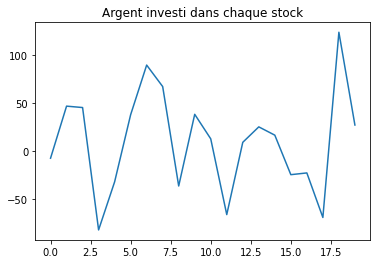

L'argent est le plus investi dans l'action: VWUSX


In [16]:
plt.plot([pos[i] for i in range(len(pos))])
plt.title("Argent investi dans chaque stock")
plt.show()
print("L'argent est le plus investi dans l'action: "+assets[np.argmax(pos)])

In [17]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([assets,pos])
for i in range(len(assets)):
    print(assets[i],pos[i].round(3))

Nombre d'action acheté pour chaque symbols: 
SPY -7.263
QQQ 46.966
VGK 45.505
SCZ -81.943
EWJ -31.875
EEM 38.045
REM 89.731
VNQ 67.365
RWX -36.2
TIP 38.458
IEF 12.913
TLT -65.987
BWX 9.286
DBC 25.375
GLD 16.741
twtr -24.408
intc -22.593
tsm -68.981
VWUSX 123.931
Amc 27.295


# Influence de alpha

In [23]:
alp = np.linspace(0.02,0.6,3)
for a in alp:
    compute_portfolio(lamb, a, Money, Pos_max_par_actif, jours_returns, periode_trades,999, gain_cible, False)

False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Iteration limit reached
False Iteration limit reached
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality

False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Iteration limit reached
False Iteration limit reached
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incom

False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Iteration limit reached
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Inequality constraints incompatible
False Iteration limit 

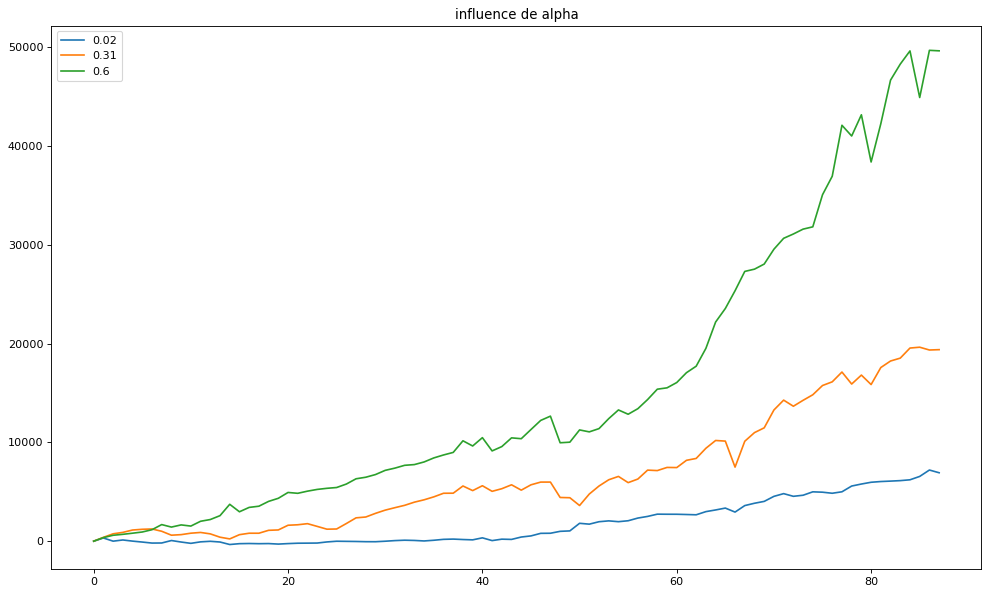

In [24]:
from matplotlib.pyplot import figure

U=[]
for x in D:
    if x not in U:
        U.append(x)


figure(figsize=(15, 9), dpi=80)

for i in range(len(U)):
    plt.plot(U[i],label=alp[i])
plt.legend()
plt.title('influence de alpha')
plt.show()

# Influence de lambda

In [ ]:
l = np.array([0,0.1,1,10])
for a in alp:
    compute_portfolio(lamb, a, Money, Pos_max_par_actif, jours_returns, periode_trades,999, gain_cible, False)

In [ ]:
from matplotlib.pyplot import figure

U=[]
for x in D:
    if x not in U:
        U.append(x)


figure(figsize=(15, 9), dpi=80)

for i in range(len(U)):
    plt.plot(U[i],label=alp[i])
plt.legend()
plt.title('influence de alpha')
plt.show()

20

In [44]:
import pyfolio as pf
import warnings
from datetime import datetime


warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


L=pd.date_range(datetime(2015,1,1),datetime(2022,1,1), periods=1+min(60,int((returns_raw.shape[0]-253)/periode_trades))).to_numpy()
#for i in range(int((all_stocks.shape[0])/periode_trades)):
 #   etape = i*periode_trades
  #  L.append(all_stocks.iloc[etape].name)

returns = pd.DataFrame()
returns['ret'] = argent_fait

returns.index = L

returns = returns['ret'].tz_localize('UTC')
#returns =returns.reindex(index=returns.index[::-1])
returns

2015-01-01 00:00:00+00:00        0.000000
2015-02-12 14:48:00+00:00      398.605190
2015-03-27 05:36:00+00:00      914.010470
2015-05-08 20:24:00+00:00      986.405936
2015-06-20 11:12:00+00:00      884.793016
                                 ...     
2021-07-14 12:48:00+00:00    12347.432932
2021-08-26 03:36:00+00:00    12221.878217
2021-10-07 18:24:00+00:00    16722.824891
2021-11-19 09:12:00+00:00    14818.287783
2022-01-01 00:00:00+00:00    15018.882574
Name: ret, Length: 61, dtype: float64

In [45]:
pf.create_full_tear_sheet(returns)

Start date,2015-01-01
End date,2022-01-01
Total months,2
,Backtest
Annual return,nan%
Cumulative returns,-9.113480618419805e+209%
Annual volatility,7743407.2%
Sharpe ratio,18.30
Calmar ratio,NaN
Stability,NaN
Max drawdown,-1.7500517346775912e+176%


IndexError: index -1 is out of bounds for axis 0 with size 0